# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install scikit-surprise

In [2]:
!pip install tqdm

In [3]:
!pip install tqdm --upgrade

In [4]:
import math
import json
import pickle
import datetime
from tqdm.notebook import tqdm_notebook


import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1 - Step

## Defining business problem

***The Main goal is to Build a Recommendation System that sugest offers wich can have a positive response of users.***

# 2 - Step

## Defining question to be asnwers in Data Analysis

- Which genre is more likely to complete an offer?
- Which gender has highest salaries? 
- Which kind of offer has more duration?
- How many users has completed offers?

# 3 - Step

## Exploratory Data Cleaning and Analysis

In [5]:
# looking for size of data set
print(f'Portfolio shape: {portfolio.shape}')  
print(f'Profile shape: {profile.shape}')  
print(f'Transcript shape: {transcript.shape}')

Portfolio shape: (10, 6)
Profile shape: (17000, 5)
Transcript shape: (306534, 4)


In [6]:
def missing_values(df):
    '''
    INPUT:
    df - A Pandas Dataframe
    
    OUTPUT:
    df_report - A pandas data frame containing Null Percentage and Column Types
    
    '''
    df_report = pd.DataFrame({'columns': df.columns,
                        'types': df.dtypes,
                        'missing_percentage': df.isna().mean()*100})
    return df_report.set_index('columns')

# Handling Missing Data

**looking for any potential missing values in Portfolio  dataframe**

In [7]:
missing_values(portfolio)

,types,missing_percentage
columns,,
channels,object,0.0
difficulty,int64,0.0
duration,int64,0.0
id,object,0.0
offer_type,object,0.0
reward,int64,0.0


**looking for any potential missing values in Transcript  dataframe**

In [8]:
missing_values(transcript)

,types,missing_percentage
columns,,
event,object,0.0
person,object,0.0
time,int64,0.0
value,object,0.0


**looking for any potential missing values in Profile  dataframe**

In [9]:
missing_values(profile)

,types,missing_percentage
columns,,
age,int64,0.000000
became_member_on,int64,0.000000
gender,object,12.794118
id,object,0.000000
income,float64,12.794118


In [10]:
profile[profile.gender.isna()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


Note:
**Here we can notice that only Profile dataframe has missing values and the percentage is too low, so we probably can drop those missinngs.**

In [11]:
u_income_age = profile[profile['income'].isna()]['age'].unique()[0]
u_income_count = len(profile[profile['income'].isna()]['age'].unique())
u_gender_age = profile[profile['gender'].isna()]['age'].unique()[0]
u_gender_count = len(profile[profile['gender'].isna()]['age'].unique())

In [12]:
# here is a prove about how we can drop the values in  profile  dataframe
print(f'Quantity of unique ages: {u_income_count}   age for missing data at incoming column: {u_income_age} ')
print(f'Quantity of unique ages: {u_gender_count}   age for missing data at gender column: {u_gender_age} ')

# the missing values seens to be in both columns at same time
profile[profile['gender'].isna()].head()

Quantity of unique ages: 1   age for missing data at incoming column: 118 
Quantity of unique ages: 1   age for missing data at gender column: 118 


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Note: **118 years old isn't a good sign, this data don't looks good. That's why i decided to drop them.**

In [13]:
def clean_profile(profile_df):
    '''
    Data cleaning the profile dataframe
    
    INPUT:
    profile_df - the profile dataframe to be cleaned
    
    OUTPUT:
    profile_df - the cleaned profile dataframe
    
    '''   
    # drop all missing values
    profile_df.dropna(inplace=True)
    
    # the number of days since the user is a member of starbucks
    profile_df['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d').dt.date
    profile_df['memberdays'] = profile_df['memberdays'].dt.days
    
    return profile_df

profile = clean_profile(profile)
print(profile.isna().sum())
profile.head()

age                 0
became_member_on    0
gender              0
id                  0
income              0
memberdays          0
dtype: int64


,age,became_member_on,gender,id,income,memberdays
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1289
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1356
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1004
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1080
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1170


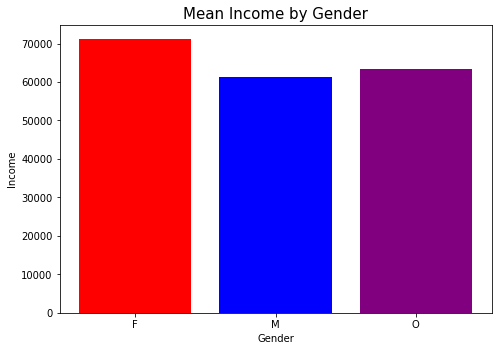

In [14]:
h_salary = profile.groupby('gender')['income'].mean()

# plot quantity of offer completed by gender
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cat = h_salary.index
values = h_salary.values
ax.bar(cat,values,color=['red', 'blue', 'purple'])
ax.set_title('Mean Income by Gender', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Income')
plt.show()

In [15]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
       
    # Display Histogram of the days being member
    plt.figure()
    memberdays = profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become our members?')
    memberdays.set_xlabel("Days")
    
    # Display Histogram of User Income
    plt.figure()
    user_income = profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")

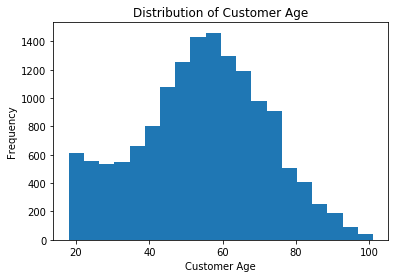

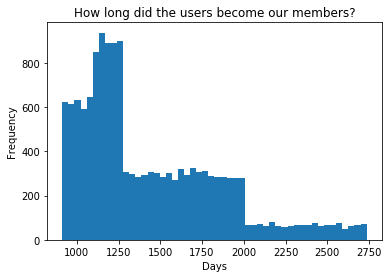

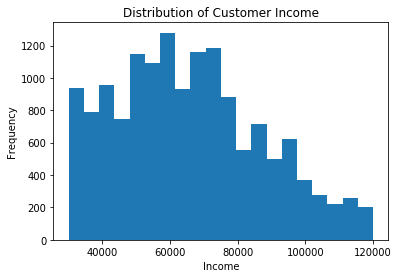

In [16]:
display_customer_profile()

# Looking the distribution

### Cheking in Portfolio  dataframe

***looking for offer type***

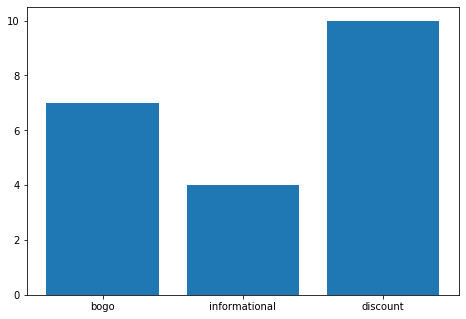

In [17]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cat = portfolio.offer_type
values = portfolio.duration
ax.bar(cat,values)
plt.show()

Note: **Looking for graph above is possible note that we have an unbalanced class in relation to offer type but discount offer seens to have more time duration**

In [18]:
mean_by_offer = portfolio.groupby('offer_type')[['duration','difficulty','reward']].mean()
print('This dataframe can cleary show that informational column has no reward involved')
mean_by_offer

This dataframe can cleary show that informational column has no reward involved


,duration,difficulty,reward
offer_type,,,
bogo,6.0,7.50,7.5
discount,8.5,11.75,3.0
informational,3.5,0.00,0.0


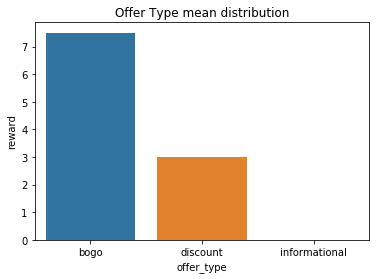

In [19]:
def sns_plot(x_val , y_val, data_in, title):
    '''
    INPUT:
    x_val -  pd.Series, list or numpy.array to xaxis
    y_val -  pd.Series, list or numpy.array to yaxis
    
    OUTPUT:
    Only a Barplot.
    '''
    sns.barplot(x = x_val,
                y = y_val,
                data = data_in).set_title(title)
    plt.show()

sns_plot(mean_by_offer.index , mean_by_offer.reward, mean_by_offer, "Offer Type mean distribution")

Note: **Looking for graph above it's possible to note that we have an unbalanced class in relation to reward, informational offer type doens't have reward linked.**

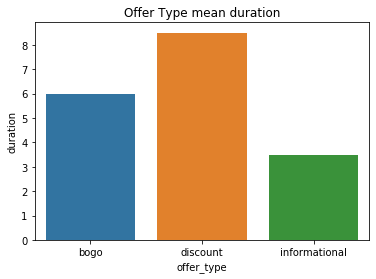

In [20]:
sns_plot(mean_by_offer.index , mean_by_offer.duration, mean_by_offer, "Offer Type mean duration")

In [21]:
# Here it's possible to note that the channel column is not good enough, that column must be cleaned. 
# Since we cannot do many things with values like a list
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [22]:
def clean_portfolio_column(df):
    '''
    INPUT:
    df - dataframe containing channels column

    OUTPUT:
    df - with channels column fixed (dummies columns created)
    '''
    # change the duration from day to hour
    df['duration'] = df['duration'] * 24
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(df['offer_type'])
    
    # Creating categorical columns in portifolio dataframe based on channel column
    df['channels'] = df.channels.astype(str)  
    df = pd.concat([df, df['channels'].str.strip('[]').str.replace("'",'').str.get_dummies(', ')], axis=1).drop('channels', axis = 1)
    
    # drop the channels and offer_type column
    df.drop(['offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([df, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

cleaned_portfolio = clean_portfolio_column(portfolio)
cleaned_portfolio.head()

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


Note: **All rows with offers type of discount and bogo has reward involved and informational doesn't.**

### Cheking in Transcript  dataframe

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


<BarContainer object of 4 artists>

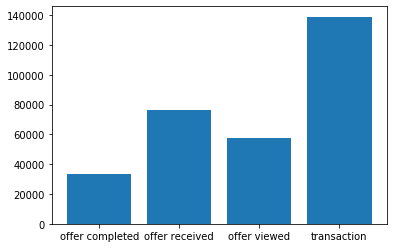

In [24]:
# ploting event column distribution
event_df = transcript.groupby('event').size()
plt.bar(event_df.index, event_df.values)

Note: **There were more transaction than any type of offer status, about 20% of completed offers in relation to transactions, analyzing offer completed is clear that most of transaction was a natural process and wasn't influenced with offers**

In [25]:
#json_normalize(data, 'counties')
import warnings
warnings.filterwarnings('ignore')

def clean_transcript(df):
    '''
    INPUT:
    df - A pandas dataframe containing transcript info

    OUTPUT:
    offer - A pandas dataframe with offer id extracted
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer


offer = clean_transcript(transcript)
print(offer.shape)

(167581, 5)


In [26]:
warnings.resetwarnings()
offer[offer['person'] == '0009655768c64bdeb2e877511632db8f'].head()

,event,person,time,value,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d


In [27]:
prof_offer = offer[['event','person','offer_id']].merge(profile, left_on= 'person', right_on='id', how= 'outer').dropna().drop_duplicates()
prof_offer_gender = prof_offer[prof_offer['event'] == 'offer completed']['gender'].value_counts()

pd.DataFrame(prof_offer[prof_offer['event'] == 'offer completed'].groupby('person').size()).shape

(11986, 1)

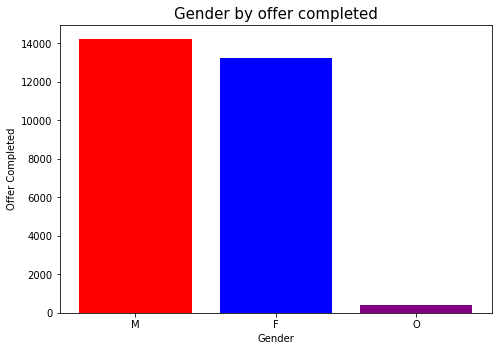

In [28]:
# plot quantity of offer completed by gender
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cat = prof_offer_gender.index
values = prof_offer_gender.values
ax.bar(cat,values,color=['red', 'blue', 'purple'])
ax.set_title('Gender by offer completed', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Offer Completed')
plt.show()

# 4 - Step

## Prepare Data to be used on modeling phase

In [29]:
def create_matrix_or_df(offer_df, portfolio_df, file_name = 'data_po', mtx= True, all_data = True):
    '''
    INPUT:
    offer_df -  Dataframe containing dummies of 'event' column
    portfolio_df -  Dataframe containing info about offers
    file_name - Name of file to be saved as pickle
    mtx - if True return a matrix and save a picke file, if Else return a DataFame and save a csv
    
    OUTPUT:
    user_item_matrix - if mtx atribute is set as True  return a dataframe formated as a matrix
    user_item_matrix - if mtx atribute is set to False  return a dataframe
    ''' 
    from tqdm.notebook import tqdm_notebook
    
    # create dataframe with only person , offer_id and event column (this last is empty)
    user_item_matrix = offer_df.groupby(['person','offer_id'])['event'].apply(lambda x: np.nan).unstack()
    
    # drop rows where offer_type are informational
    user_item_matrix.drop(list(portfolio_df[portfolio_df['offer_type']=='informational']['id']), axis=1, inplace=True)
    
   
    # fill offer completed collumn based on following coditions: 
        # if there were offer completed, viewed and received  = 1 (Positive feel about offer)
        # if there were't offer completed but had viewed and received  = 0 (Negative feel about offer)
        # Otherwise NaN (Didn't view or didn't received offer)
    for offer_id in tqdm_notebook(user_item_matrix.columns):

        for person in tqdm_notebook(user_item_matrix.index):
            events = []

            for event in offer_df[(offer_df['offer_id']==offer_id) & (offer_df['person']==person)]['event']:
                events.append(event)

            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):

                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1

            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0

     
    if mtx and all_data:
        # store the large martix into file
        user_item_matrix.to_pickle(f'{file_name}_mtx.pkl')
        
        # create an pickle from formated as a dataframe
        user_item_format = user_item_matrix.unstack()
        user_item_format.to_pickle(f'{file_name}_table.pkl')
        
        return user_item_format, user_item_matrix
    
    elif mtx and (all_data is False):
        # store the large martix into file
        user_item_matrix.to_pickle(f'{file_name}.pkl')
        return user_item_matrix
    
    # create an pickle from formated as a dataframe
    user_item_format = user_item_matrix.unstack()
    user_item_format.to_pickle(f'{file_name}.pkl')
    
    return user_item_format

***Important note:*** 



 ***To Avoid Using the function 'create_matrix_or_df', since is time consuming, use pickle command instead to get  data processed***
 
 
The process below may take up to about 90-100 mins to process, if you chose dont to use pickle

In [30]:
#data_formated, user_mtx = create_matrix_or_df(offer, portfolio,'data_po')

# To Avoid Using the function above, since is time consuming you can use pickle comands below, is the data already preprocessed
data_formated = pd.read_pickle("data_po_table.pkl") # data to be used on Surprise, to read you must add .pkl extension when passing string
user_mtx = pd.read_pickle("data_po_mtx.pkl") # matrix to be used in funkSVD function, to read you must add .pkl extension

In [31]:
user_mtx.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


# 5 - Step

## Train, Test and Validation model

***The Main goal is to Build a Recommendation System here i decided to use two diferent ways, using surprise package and implement FunkSVD by hand.***

# Colaborative Filtering using Scikit Surprise!

In [32]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [33]:
# Here we may drop nulls since surprise doesn't handle dataframe with null values
data_surprise = pd.DataFrame(data_formated).reset_index().rename(columns= {0 : 'offer_completed'}).dropna()
data_surprise.head()

,offer_id,person,offer_completed
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1.0
5,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,0.0
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,0.0
10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,0.0
11,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,0.0


In [34]:
from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, KNNBasic, KNNWithMeans, KNNWithZScore, CoClustering
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

reader = Reader()
data = Dataset.load_from_df(data_surprise[['person', 'offer_id', 'offer_completed']].drop_duplicates(), reader)

### Applying Cross Validation on all data to find best model

***Important note: this cell below is time consuming.***

***This process may take up to  about 50-60 mins to process in udacity workspace***

***Took about 5 min on my local machine (=.=) ***

In [35]:
cv = []
# Iterate over all recommender system algorithms
for recsys in tqdm_notebook([SVD(), SVDpp(), KNNWithZScore(), CoClustering(),KNNWithMeans()]):
    # Perform cross validation
    tmp = cross_validate(recsys, data, measures=['RMSE'], cv=3, verbose=False)
    cv.append((str(recsys).split(' ')[0].split('.')[-1], tmp['test_rmse'].mean()))


  0%|          | 0/5 [00:00<?, ?it/s]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [36]:
# Visualize best models in a datafram format
best_cv= pd.DataFrame(cv, columns=['RecSys', 'RMSE'])

In [37]:
# Create easy access to models
model_dict = {'SVD': SVD(), 'SVDpp': SVDpp(), 'KNNWithZScore': KNNWithZScore(),'CoClustering': CoClustering(), 'KNNWithMeans':KNNWithMeans()}

# Get the best name model based on RMSE
model_cv = best_cv[best_cv['RMSE'] == best_cv['RMSE'].min()]['RecSys'].values[0]

In [38]:
# Spliting Train and test set
trainset, testset = train_test_split(data, test_size=0.20)
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  16514 

Number of items:  8 



In [39]:
unique_user_id = data_surprise['person'].unique()

# get the list of the ids that the userid has rated
unique_item_ids = data_surprise.loc[data_surprise['person']=='747f706b685144b29bbc8a0f209432ec', 'offer_id']

# remove the rated offers for the recommendations
offers_to_predict = np.setdiff1d(unique_user_id, unique_item_ids)

# fit best model in cross validation
algo = model_dict[model_cv]
algo.fit(data.build_full_trainset())
my_recs = []

# get all offers of a specifc user id
for iid in offers_to_predict:
    my_recs.append((iid, algo.predict(uid='747f706b685144b29bbc8a0f209432ec',iid=iid).est))
    

# Making a dataframe to easy vizualize wich one top similar users
top_users_sim = pd.DataFrame(my_recs, columns=['Uid', 'predictions']).sort_values('predictions', ascending=False).head(8)
top_users_sim.head()

,Uid,predictions
0,0009655768c64bdeb2e877511632db8f,1
11290,a93cb9e04f5a4ffa8beeb6e6a51333ca,1
11276,a9012cc8c7d94d2aae450ea4c314d394,1
11277,a9035280036b4e21bfe017153319c1b3,1
11278,a906be760afd4edb815302cab24a60d6,1


In [40]:
# the most similar user
common_elements = list(np.intersect1d(list(top_users_sim['Uid']), list(profile['id'])))

profile[profile['id'].isin(common_elements)]

,age,became_member_on,gender,id,income,memberdays
1431,19,20150824,M,a906c9eb943e4fbab2655d893a372705,46000.0,1980
3793,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0,1374
6674,31,20130915,M,a9035280036b4e21bfe017153319c1b3,58000.0,2688
9744,76,20170823,M,a90cad5df2e44266abbea4736c061ec7,86000.0,1250
10738,58,20171204,M,a90ef297656f4150af47cd391adf276a,39000.0,1147
11952,35,20180531,F,a906be760afd4edb815302cab24a60d6,65000.0,969
14994,40,20170210,M,a93cb9e04f5a4ffa8beeb6e6a51333ca,41000.0,1444


### Applying Grid Search in best model

***Important note:*** 

   ***this cell is time consuming, with those params i couldn't beat Surprise CV, you can chose less combinations in 'n_factors', 'n_epochs', 'lr_all' and 'reg_all'. If you do it probably will be faster, but still won't beat Built-in Cross Validation of Surprise Lib.*** 
    
   **This process may take up to  2 hour to process on udacity workspace**

In [44]:
print(model_cv)

SVD


In [45]:
# Initialize Grid Search
param_grid = {'n_factors': [4,8,15],'n_epochs': [15,30], 'lr_all': [0.002, 0.005,0.01],'reg_all':[0.02,0.1,0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Get best parameters for RMSE metric
params = gs.best_params['rmse']

# Set parameters at best model from cross validation
model_tuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

# Fit and train the model with best params
model_tuned.fit(trainset)
predictions = model_tuned.test(testset)

print(accuracy.rmse(predictions))

RMSE: 0.8052
0.8052331798514324


***Geting top N Offer recommendations***

In [46]:
# Get top N predicitions for users in test set
top_n = get_top_n(predictions, n=5)
my_recs = {}

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    recs = [iid for (iid, _) in user_ratings]
    my_recs[uid] = recs
    print(f'User : {uid} \n------> recommendation: {recs}')
    


User : 8b52e9bd7cf1409ca13519014132a239 
------> recommendation: ['4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9']
User : 25289293a27140a6884abcf45087e8a2 
------> recommendation: ['fafdcd668e3743c1bb461111dcafc2a4']
User : c098b26dfe904bb691d9c43c525ee279 
------> recommendation: ['4d5c57ea9a6940dd891ad53e9dbe8da0']
User : e3d76b6e78c542f682a6a3bb7c3d275b 
------> recommendation: ['f19421c1d4aa40978ebb69ca19b0e20d']
User : 5dda3558f4704bf9a5e46c115cf2f6b7 
------> recommendation: ['9b98b8c7a33c4b65b9aebfe6a799e6d9', '2906b810c7d4411798c6938adc9daaa5']
User : afe0e930e2fc4e72b88d7e289237ba00 
------> recommendation: ['0b1e1539f2cc45b7b9fa7c272da2e1d7']
User : 9aa538ebf4704f10b8c53e221e6e1efe 
------> recommendation: ['4d5c57ea9a6940dd891ad53e9dbe8da0', 'ae264e3637204a6fb9bb56bc8210ddfd']
User : 199a0cb9068941d5a520b891e0d1e9ae 
------> recommendation: ['9b98b8c7a33c4b65b9aebfe6a799e6d9']
User : c8d495a12bd049489dd2d185cd20bfc3 
------> recommendation: ['4d5c57ea9

------> recommendation: ['2906b810c7d4411798c6938adc9daaa5']
User : 95ba904ccb2b4a22bd1fa14321e98488 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2', 'f19421c1d4aa40978ebb69ca19b0e20d']
User : b3a7a0a62e3445f69bf1f26a3447d6e0 
------> recommendation: ['2906b810c7d4411798c6938adc9daaa5']
User : cc78f8a770c64097a5f2cc4676a8e290 
------> recommendation: ['2906b810c7d4411798c6938adc9daaa5']
User : ca98c3611fb044e581ad34f2b4bcf1f6 
------> recommendation: ['4d5c57ea9a6940dd891ad53e9dbe8da0']
User : 0ebc3c4c39234ab6a2701fe2525705a9 
------> recommendation: ['9b98b8c7a33c4b65b9aebfe6a799e6d9']
User : 0903e02ddbb7438f8de18081d1595a34 
------> recommendation: ['ae264e3637204a6fb9bb56bc8210ddfd', 'fafdcd668e3743c1bb461111dcafc2a4']
User : 31bf20236dda4f92b15153c439352a25 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2']
User : 32e149f18abe4a0a8555707ea9e99749 
------> recommendation: ['9b98b8c7a33c4b65b9aebfe6a799e6d9']
User : 4d4216b868fe43ddb9c9f0b77212c0cb 
------> re

------> recommendation: ['f19421c1d4aa40978ebb69ca19b0e20d']
User : 85cd46f955af4aeb856e34a83125fc75 
------> recommendation: ['fafdcd668e3743c1bb461111dcafc2a4', 'ae264e3637204a6fb9bb56bc8210ddfd']
User : 4a737483c1f947d0b06e5b898448b3e8 
------> recommendation: ['ae264e3637204a6fb9bb56bc8210ddfd', '0b1e1539f2cc45b7b9fa7c272da2e1d7']
User : ed05efcd8e7a49ef835fa6c1c29247a4 
------> recommendation: ['4d5c57ea9a6940dd891ad53e9dbe8da0', '2906b810c7d4411798c6938adc9daaa5']
User : 4de40fe3c0584dc3ab113d87c1e77904 
------> recommendation: ['9b98b8c7a33c4b65b9aebfe6a799e6d9']
User : 7e684e29d55d4003a95a8e70c04d973f 
------> recommendation: ['0b1e1539f2cc45b7b9fa7c272da2e1d7']
User : 9a0e465c898540a9b6221a6ddca88f60 
------> recommendation: ['f19421c1d4aa40978ebb69ca19b0e20d']
User : dcdf92e161ce4af690a34ef800b3e925 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2', 'f19421c1d4aa40978ebb69ca19b0e20d']
User : 8f2d36e9780b4ce095e53920740e72b3 
------> recommendation: ['f19421c1d4aa40

------> recommendation: ['9b98b8c7a33c4b65b9aebfe6a799e6d9']
User : d10c2674404040778c0bf927ef316082 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2']
User : 2c7f7d16d67442158d99ee0a5ea6ab6c 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2']
User : 21da6ca3b11e4949b917f750cc886c63 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2']
User : 21c0a28f6b8c4de08536ecf97aea4286 
------> recommendation: ['f19421c1d4aa40978ebb69ca19b0e20d']
User : 6c489cb73b4e4241bd292ba332e2ee8c 
------> recommendation: ['fafdcd668e3743c1bb461111dcafc2a4']
User : 05f5d803302a40d78b0724c86022c7cc 
------> recommendation: ['0b1e1539f2cc45b7b9fa7c272da2e1d7']
User : d7f862d7f4404fcfacc123ea45cf2b3e 
------> recommendation: ['f19421c1d4aa40978ebb69ca19b0e20d']
User : 0973a73fb67147e09659b92bc511eb78 
------> recommendation: ['2906b810c7d4411798c6938adc9daaa5']
User : 91cec8d70c5a4c5aa04a0ee01653e5ad 
------> recommendation: ['2298d6c36e964ae4a3e7e9706d1fb8c2']
User : 5790832a6dd84f

In [47]:
my_recs['747f706b685144b29bbc8a0f209432ec']

['9b98b8c7a33c4b65b9aebfe6a799e6d9']

### Note: 
   ***Here we was unable to make more than 3 prediction per user, this means that the data set is very sparse and we dont have so many data with a good amount of offers completed or at least received and viwed, evaluating the Surprise we got an RMSE of 0.7991 for user Similarity when using built-in Cross Validation, but with Grid Search  we didn't but probably can reach better results but its still time consuming.***

# Funk SVD by hand

In [48]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    num_users = complete_mat.shape[0]
    num_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(num_users, latent_features)
    offer_mat = np.random.rand(latent_features, num_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    result = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
 
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(num_users):
            for j in range(num_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [49]:
def train_test(df, train_proportion = 0.7):
    '''Split train test based on proportion given an train set proportion
    
    INPUT:
    df - The pandas DataFrame to be splited
    
    OUTPUT:
    train_data - Slice of dataframe corresponding to  train_proportion
    test_data - Slice of dataframe corresponding to  1 - train_proportion
    '''
    # make the split random
    df = df.sample(frac = 1).reset_index(drop=True) 
    
    # create index for spliting
    train_size = int(df.shape[0]*train_proportion)
    
    # split data 
    train_data = df[:train_size]
    test_data = df[train_size:]
    
    return train_data, test_data

In [50]:
def predict_user_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    INPUT:
    user_matrix - User by latent factor matrix
    offer_matrix - Latent factor by offer matrix
    user_id - The user_id from the reviews df
    offer_id - The offer_id according the offers df
    
    OUTPUT:
    reaction_prediction - The predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_offer.index)
        offer_ids_series = np.array(train_offer.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        reaction_prediction = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return reaction_prediction
    
    except:
        return None

In [51]:
def eval_recommendations(test_df, user_mat, offer_mat):
    '''
    INPUT:
    test_df - test pandas Dataframe matrix 
    user_mat - user by latent factor matrix
    offer_mat - latent factor by offer matrix
    
    OUTPUT:
    Result metric printed
    '''
    
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_user_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_user_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [52]:
def top_sale_offer(user_item_matrix):
    '''
    INPUT:
    user_item_matrix - A pandas dataframe with all data formated as matrix
    
    OUTPUT:
    offer_value - A pandas dataframe countaining all offers ordered in descending for popularity
    '''

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([
                           offer_id, 
                           transcript[(transcript['person'].isin(
                                    list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))& \
                                    (transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()
                          ]
                         )

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [53]:
def make_recommendation(user_id, user_mat, offer_mat, all_data_matrix, train_df):
    '''
    INPUT:
    user_id - The user id to be predicted
    user_mat - User by latent factor matrix
    offer_mat - Latent factor by offer matrix
    
    OUTPUT:
    Result metric printed
    '''
    
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_user_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    
    if pred_val == None:
        top_offer = top_sale_offer(all_data_matrix)
        print("Since there is no record of this user we can recommend top offers")
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [54]:
# Split offer DataFrame
train_slice , test_slice= train_test(offer)

***Important note:*** 

   ***To Avoid Using the function 'create_matrix_or_df', since is time consuming (about 90 min for train_offer and 40 min for test),  use pickle command instead***

In [82]:
# create matrix for train data
#train_offer = create_matrix_or_df(train_slice, portfolio, 'train', all_data = False)

# create matrix for test data
#test_offer = create_matrix_or_df(test_slice, portfolio, 'test',  all_data = False)

# Read pickle
train_offer = pd.read_pickle("train.pkl") 
test_offer = pd.read_pickle("test.pkl")

In [56]:
# Changing format of train data as funkSVD expect
train_data_np = np.array(train_offer)

In [57]:
# Users in common that has in both train and test set
common_elements = list(np.intersect1d(list(test_offer.index), list(train_offer.index)))

***Fit and look for best params***

In [58]:
# fit model with defalt params
u_mtx, o_mtx = FunkSVD(train_data_np)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 1.223840
2 		 0.094053
3 		 0.083412
4 		 0.075309
5 		 0.068650
6 		 0.063176
7 		 0.058674
8 		 0.054972
9 		 0.051927
10 		 0.049420
11 		 0.047357
12 		 0.045659
13 		 0.044261
14 		 0.043109
15 		 0.042160
16 		 0.041379
17 		 0.040735
18 		 0.040204
19 		 0.039766
20 		 0.039406
21 		 0.039108
22 		 0.038863
23 		 0.038660
24 		 0.038493
25 		 0.038355
26 		 0.038242
27 		 0.038148
28 		 0.038070
29 		 0.038006
30 		 0.037953
31 		 0.037910
32 		 0.037873
33 		 0.037844
34 		 0.037819
35 		 0.037799
36 		 0.037782
37 		 0.037768
38 		 0.037756
39 		 0.037747
40 		 0.037739
41 		 0.037732
42 		 0.037727
43 		 0.037722
44 		 0.037719
45 		 0.037715
46 		 0.037713
47 		 0.037711
48 		 0.037709
49 		 0.037708
50 		 0.037706
51 		 0.037705
52 		 0.037704
53 		 0.037704
54 		 0.037703
55 		 0.037703
56 		 0.037702
57 		 0.037702
58 		 0.037702
59 		 0.037701
60 		 0.037701
61 		 0.037701
62 		 0.037701
63 		 0.037701
64 		 0

In [59]:
# fit model with latent_features = 8 , learning_rate= 0.005 and number of iteration = 250
u_mtx_8 , o_mtx_8= FunkSVD(train_data_np, latent_features=8, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.060330
2 		 0.038282
3 		 0.038280
4 		 0.038279
5 		 0.038278
6 		 0.038277
7 		 0.038276
8 		 0.038275
9 		 0.038274
10 		 0.038273
11 		 0.038272
12 		 0.038271
13 		 0.038270
14 		 0.038268
15 		 0.038267
16 		 0.038266
17 		 0.038265
18 		 0.038264
19 		 0.038263
20 		 0.038262
21 		 0.038261
22 		 0.038260
23 		 0.038259
24 		 0.038258
25 		 0.038256
26 		 0.038255
27 		 0.038254
28 		 0.038253
29 		 0.038252
30 		 0.038251
31 		 0.038250
32 		 0.038248
33 		 0.038247
34 		 0.038246
35 		 0.038245
36 		 0.038244
37 		 0.038243
38 		 0.038242
39 		 0.038240
40 		 0.038239
41 		 0.038238
42 		 0.038237
43 		 0.038236
44 		 0.038234
45 		 0.038233
46 		 0.038232
47 		 0.038231
48 		 0.038230
49 		 0.038228
50 		 0.038227
51 		 0.038226
52 		 0.038225
53 		 0.038223
54 		 0.038222
55 		 0.038221
56 		 0.038220
57 		 0.038218
58 		 0.038217
59 		 0.038216
60 		 0.038214
61 		 0.038213
62 		 0.038212
63 		 0.038211
64 		 0

In [60]:
# fit model with latent_features = 6 , learning_rate= 0.005 and number of iteration = 250
u_mtx_6 , o_mtx_6 = FunkSVD(train_data_np, latent_features=6, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.056740
2 		 0.038146
3 		 0.038145
4 		 0.038144
5 		 0.038143
6 		 0.038141
7 		 0.038140
8 		 0.038139
9 		 0.038137
10 		 0.038136
11 		 0.038135
12 		 0.038133
13 		 0.038132
14 		 0.038131
15 		 0.038130
16 		 0.038128
17 		 0.038127
18 		 0.038126
19 		 0.038124
20 		 0.038123
21 		 0.038121
22 		 0.038120
23 		 0.038119
24 		 0.038117
25 		 0.038116
26 		 0.038115
27 		 0.038113
28 		 0.038112
29 		 0.038110
30 		 0.038109
31 		 0.038108
32 		 0.038106
33 		 0.038105
34 		 0.038103
35 		 0.038102
36 		 0.038100
37 		 0.038099
38 		 0.038097
39 		 0.038096
40 		 0.038095
41 		 0.038093
42 		 0.038092
43 		 0.038090
44 		 0.038089
45 		 0.038087
46 		 0.038086
47 		 0.038084
48 		 0.038083
49 		 0.038081
50 		 0.038079
51 		 0.038078
52 		 0.038076
53 		 0.038075
54 		 0.038073
55 		 0.038072
56 		 0.038070
57 		 0.038068
58 		 0.038067
59 		 0.038065
60 		 0.038064
61 		 0.038062
62 		 0.038060
63 		 0.038059
64 		 0

In [61]:
# fit model with latent_features = 4 , learning_rate= 0.005 and number of iteration = 250
u_mtx_4 , o_mtx_4 = FunkSVD(train_data_np, latent_features=4, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.047793
2 		 0.038065
3 		 0.038064
4 		 0.038063
5 		 0.038062
6 		 0.038060
7 		 0.038059
8 		 0.038057
9 		 0.038056
10 		 0.038055
11 		 0.038053
12 		 0.038052
13 		 0.038050
14 		 0.038049
15 		 0.038048
16 		 0.038046
17 		 0.038045
18 		 0.038043
19 		 0.038042
20 		 0.038041
21 		 0.038039
22 		 0.038038
23 		 0.038036
24 		 0.038035
25 		 0.038033
26 		 0.038032
27 		 0.038031
28 		 0.038029
29 		 0.038028
30 		 0.038026
31 		 0.038025
32 		 0.038023
33 		 0.038022
34 		 0.038020
35 		 0.038019
36 		 0.038017
37 		 0.038016
38 		 0.038014
39 		 0.038013
40 		 0.038011
41 		 0.038010
42 		 0.038008
43 		 0.038007
44 		 0.038005
45 		 0.038004
46 		 0.038002
47 		 0.038001
48 		 0.037999
49 		 0.037998
50 		 0.037996
51 		 0.037995
52 		 0.037993
53 		 0.037992
54 		 0.037990
55 		 0.037989
56 		 0.037987
57 		 0.037985
58 		 0.037984
59 		 0.037982
60 		 0.037981
61 		 0.037979
62 		 0.037977
63 		 0.037976
64 		 0

In [62]:
# Making evaluatuin at test set for 8 latent features
eval_recommendations(test_offer, u_mtx_8, o_mtx_8)

0.007906334453546503


In [63]:
# Making evaluatuin at test set for 6 latent features
eval_recommendations(test_offer, u_mtx_6, o_mtx_6)

0.007949843513801264


In [64]:
# Making evaluatuin at test set for 4 latent features
eval_recommendations(test_offer, u_mtx_4, o_mtx_4)

0.007383172887544294


In [67]:
# Making evaluatuin at test set for 12 latent features
eval_recommendations(test_offer, u_mtx, o_mtx)

0.007395884487620618


In [65]:
# get an user that has at least one recommendation or is presented at train and test set at the same time
common_elements = list(np.intersect1d(list(train_offer.index), list(test_offer.index)))

make_recommendation(common_elements[5], u_mtx, o_mtx, user_mtx, train_offer)

recommend offer for user  06ab01a0775d4b35bceca2d607271874
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.04
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.03
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.02
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.02
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.02
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.02
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.01
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.01


Since there is no record of this user we can recommend top offers
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


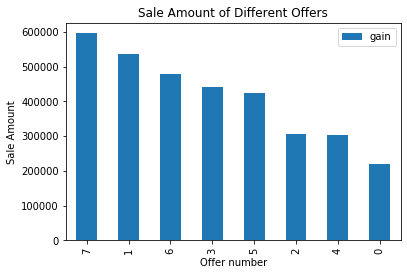

In [66]:
# recommend offer for an unknow user
make_recommendation('unknow', u_mtx, o_mtx, user_mtx, train_offer)

# Model Discuss

***The model selected for the tests which had 8 latent features, a learning rate of 0.005 and 250 iterations, had the lowest RMSE, this implies that it manages to generalize better. For unknow users was implemented Ranked based  approach selecting the items rated from the best to the worst in terms of feeling positive about the offers.***

***The RMSE for this approach is for the selected products and not about the most similar users as in the Surprise library. In general this aproach seens to perform better than Surprise lib at least can make more than 3 predictions per user, and new or few records users can get ranked based recommendation.***

# Conclusions

 ***This project was a huge challenge, to implement the model at hand it was very difficult in particular to make a User X Offer matrix, once the processing time was the Gap, after that the understanding of the surprise library took some time. What really made me very happy was the know that the model implemented in the hand had a very low RMSE, which was the metric chosen.***

 **Of all the models used to create the recommendation system, it was possible to notice that the SVD had the best performance both using cross-validation with the surprise library, and when implementing the model by hand. It was possible to notice two different forms of implementation, the surprise which is very interesting for fast projects due to its similarity with the 
sci-kit learn, easily usable and implementable.**

 **However, it is possible to realize that he has his shortcomings and difficulties, the recommendation returns the most similar users and it is necessary to carry out a further treatment to find the recommendations, another point is that many users had few recommendations this is due to the low amount of rates user or even the lack of records for this user.
On the other hand, when implementing a model manually, you are free to make changes and create a more generalizable model, combining several approaches in one system.**

 **Prossible model improvement:**

    - by decreasing data sparsity, since there are few records in which there is actually a positive or negative connotation.
    - Use hyperparameter tuning with gridSerchCV with more time (increase the number of options).
    - Clustering by gender and age, before training the model
    - A / B testing to improve the impact of recommendations


 **Next steps:**  

 This work can only be a gateway for the implementation of other prediction systems such as:

    - forecast the amount of financial return related to advertising 
    - more effective grouping of advertisements according to gender and age
    - inventory forcasting
        
        


